In [40]:
import scipy.io
import numpy as np
from sklearn.metrics import auc
import pingouin as pg
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statistics import variance, mean


In [41]:

hc_data_path = '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/HC/CharPath240_binwin_HC.mat'
st_data_path = '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/ST/CharPath240_binwin.mat'

In [42]:
outcome_var = 'LocEfficiency'
minimum_connectivity_threshold = 0.3

In [43]:
hc_data_mat = scipy.io.loadmat(hc_data_path)
st_data_mat = scipy.io.loadmat(st_data_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/ST/CharPath240_binwin.mat'

In [5]:
n_thresholds = len(hc_data_mat[outcome_var][0][0])

In [6]:
# converting matlab mat to arrays
# transposing to have shape (n_subj, n_thresholds)
hc_loc_eff = np.swapaxes(np.array(
                    [np.vstack(hc_data_mat[outcome_var][0][0][i]).T
                     for i in range(n_thresholds)]
                ), 0, -1)
st0_loc_eff = np.swapaxes(np.array(
                    [np.vstack(st_data_mat[outcome_var][0][0][0][0][0][i]).T
                     for i in range(n_thresholds)]
                ), 0, -1)
st1_loc_eff = np.swapaxes(np.array(
                    [np.vstack(st_data_mat[outcome_var][0][0][1][0][0][i]).T
                     for i in range(n_thresholds)]
                ), 0, -1)
st2_loc_eff = np.swapaxes(np.array(
                    [np.vstack(st_data_mat[outcome_var][0][0][2][0][0][i]).T
                     for i in range(n_thresholds)]
                ), 0, -1)

In [7]:
n_hc = hc_loc_eff.shape[0]
n_st = st0_loc_eff.shape[0]

In [8]:
# only analyse thresholds above minimum_connectivity_threshold
minimum_connectivity_threshold_index = int(minimum_connectivity_threshold*10 - 1)
connectivity_thresholds = np.arange(minimum_connectivity_threshold, 1.1, 0.1)

In [9]:
# use auc only over predefined area of thresholds
def custom_auc(values_over_thresholds):
    return auc(connectivity_thresholds,
                values_over_thresholds[minimum_connectivity_threshold_index:])

In [10]:
hc_loc_eff_auc = np.apply_along_axis(custom_auc, arr=hc_loc_eff, axis=-1)
st0_loc_eff_auc = np.apply_along_axis(custom_auc, arr=st0_loc_eff, axis=-1)
st1_loc_eff_auc = np.apply_along_axis(custom_auc, arr=st1_loc_eff, axis=-1)
st2_loc_eff_auc = np.apply_along_axis(custom_auc, arr=st2_loc_eff, axis=-1)

In [11]:
all_subj_idx = np.arange(n_hc + n_st)
hc_idx = all_subj_idx[:n_hc]
st_idx = all_subj_idx[n_hc:]

In [12]:
hc_loc_eff_auc_df = pd.DataFrame(data=hc_loc_eff_auc)
hc_loc_eff_auc_df['subject'] = hc_idx
hc_loc_eff_auc_df = hc_loc_eff_auc_df.melt(id_vars=['subject'], var_name='roi', value_name='loc_eff_auc')
hc_loc_eff_auc_df['timepoint'] = 0
hc_loc_eff_auc_df['group'] = 'hc'

In [13]:
st0_loc_eff_auc_df = pd.DataFrame(data=st0_loc_eff_auc)
st0_loc_eff_auc_df['subject'] = st_idx
st0_loc_eff_auc_df = st0_loc_eff_auc_df.melt(id_vars=['subject'], var_name='roi', value_name='loc_eff_auc')
st0_loc_eff_auc_df['timepoint'] = 0
st0_loc_eff_auc_df['group'] = 'st'

In [14]:
st1_loc_eff_auc_df = pd.DataFrame(data=st1_loc_eff_auc)
st1_loc_eff_auc_df['subject'] = st_idx
st1_loc_eff_auc_df = st1_loc_eff_auc_df.melt(id_vars=['subject'], var_name='roi', value_name='loc_eff_auc')
st1_loc_eff_auc_df['timepoint'] = 1
st1_loc_eff_auc_df['group'] = 'st'

In [15]:
st2_loc_eff_auc_df = pd.DataFrame(data=st2_loc_eff_auc)
st2_loc_eff_auc_df['subject'] = st_idx
st2_loc_eff_auc_df = st2_loc_eff_auc_df.melt(id_vars=['subject'], var_name='roi', value_name='loc_eff_auc')
st2_loc_eff_auc_df['timepoint'] = 2
st2_loc_eff_auc_df['group'] = 'st'

In [16]:
loc_eff_auc_df = pd.concat([hc_loc_eff_auc_df,st0_loc_eff_auc_df, st1_loc_eff_auc_df, st2_loc_eff_auc_df],
                            ignore_index=True)
all_st_loc_eff_auc_df = pd.concat([st0_loc_eff_auc_df, st1_loc_eff_auc_df, st2_loc_eff_auc_df],
                            ignore_index=True)

In [17]:
# convert auc to numeric
loc_eff_auc_df['loc_eff_auc'] = loc_eff_auc_df['loc_eff_auc'].astype('float')
all_st_loc_eff_auc_df['loc_eff_auc'] = all_st_loc_eff_auc_df['loc_eff_auc'].astype('float')

# convert timepoint to numeric
loc_eff_auc_df['timepoint'] = loc_eff_auc_df['timepoint'].astype('float')
all_st_loc_eff_auc_df['timepoint'] = all_st_loc_eff_auc_df['timepoint'].astype('float')

In [18]:
loc_eff_auc_df.head()

,subject,roi,loc_eff_auc,timepoint,group
0,0,0,0.105834,0.0,hc
1,1,0,0.196915,0.0,hc
2,2,0,0.131735,0.0,hc
3,3,0,0.144501,0.0,hc
4,4,0,0.097384,0.0,hc


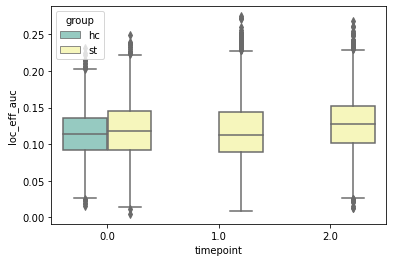

In [19]:
sns.boxplot(x="timepoint", y="loc_eff_auc", hue="group", data=loc_eff_auc_df, palette="Set3")
plt.show()


In [139]:
loc_eff_auc_df.to_csv('loc_eff_auc_df.csv', index=False)

## Post hoc analysis
Patient time points vs controls



In [32]:
controls = loc_eff_auc_df[loc_eff_auc_df['group']=='hc']['loc_eff_auc']
print('Variance controls:' + str(variance(controls)))
mean(controls)

0.11400298022816241

In [ ]:
# controls vs patients at all timepoints
ttest_ind(controls, st_tp0, equal_var=False)


In [35]:
# controls vs patients at time point 0
st_tp0 = loc_eff_auc_df[(loc_eff_auc_df['group']=='st') & (loc_eff_auc_df['timepoint']==0)]['loc_eff_auc']
print('Variance subjects:' + str(variance(st_tp0)))
mean(st_tp0)

Variance subjects:0.0014529062450121242


0.11932582991729744

In [39]:
ttest_ind(controls, loc_eff_auc_df[loc_eff_auc_df['group']=='st']['loc_eff_auc'], equal_var=False)

Ttest_indResult(statistic=-12.094493228734626, pvalue=2.1440553597605035e-33)

In [37]:
# controls vs patients at time point 0
st_tp1 = loc_eff_auc_df[(loc_eff_auc_df['group']=='st') & (loc_eff_auc_df['timepoint']==1)]['loc_eff_auc']
print('Variance subjects:' + str(variance(st_tp1)))
mean(st_tp1)

Variance subjects:0.001866389817142183


0.1185912646408121

In [38]:
ttest_ind(controls, st_tp1, equal_var=False)

Ttest_indResult(statistic=-5.150734848887631, pvalue=2.6690596194271994e-07)